# Fine-Tuning Vision Transformers for Image Classification through Fast AI

The goal of this notebook is to create an image classifier for sattelite images, using fast ai on the EUROSAT dataset.
We will fine-tune a Vision Transformer (ViT), as research shows this is the best approach for multi-class classification [1].

Base source: https://timm.fast.ai/

# Packages

In [ ]:
!pip install timm

In [ ]:
import os
import timm, torch
from fastai.vision.all import ImageDataLoaders, get_image_files, Resize
from fastai.vision.all import vision_learner, error_rate
from fastai.vision.all import ClassificationInterpretation
from fastai.vision.all import load_learner

# Check that GPU acceleration is available
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


# Data

In [ ]:
# Download and unzip locally to avoid syncing problems
!wget --no-check-certificate -P /content/ https://madm.dfki.de/files/sentinel/EuroSAT.zip

!unzip -u -q /content/EuroSAT.zip -d /content/EuroSAT

In [ ]:
!ls EuroSAT

2750


In [ ]:
path = '/content/EuroSAT/2750'
def label_func(x): return x.parent.name
fnames = get_image_files(path)
print(len(fnames))
dls = ImageDataLoaders.from_path_func(
    path, fnames, valid_pct=0.2,
    label_func=label_func, item_tfms=Resize(224))

27000


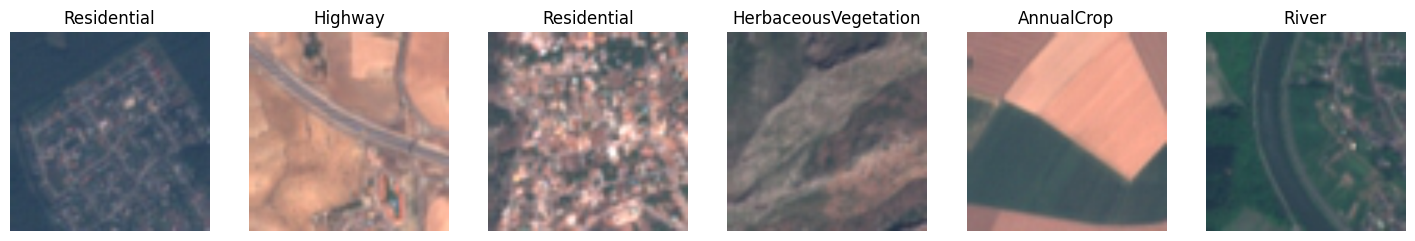

In [ ]:
dls.train.show_batch(max_n=6, nrows=1)

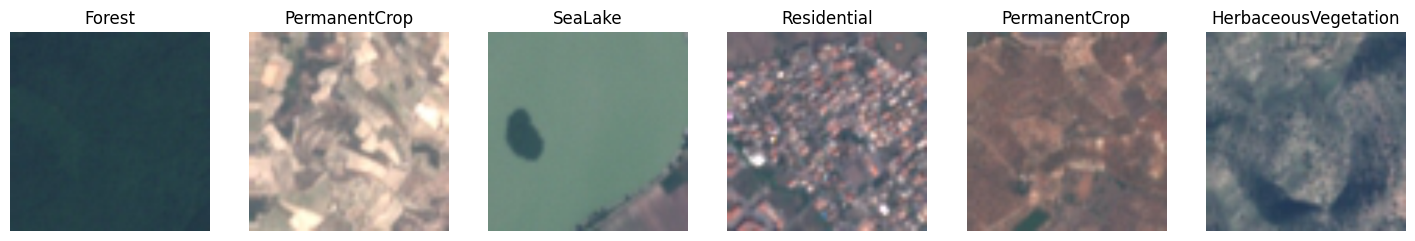

In [ ]:
dls.valid.show_batch(max_n=6, nrows=1)

#Model & Training

In [ ]:
# if a string is passed into the model argument, it will now use timm (if it is installed)
learn = vision_learner(dls, 'vit_tiny_patch16_224', metrics=error_rate)

learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.429636,0.186883,0.060370,01:26


epoch,train_loss,valid_loss,error_rate,time
0,0.196535,0.115031,0.038889,01:37
1,0.125553,0.077501,0.026481,01:41
2,0.090919,0.062862,0.020000,01:40
3,0.073000,0.063406,0.019444,01:38
4,0.040245,0.052481,0.015926,01:39
5,0.033671,0.056608,0.017778,01:38
6,0.017223,0.060251,0.017222,01:38
7,0.014844,0.054341,0.015370,01:37
8,0.007291,0.054880,0.016852,01:39
9,0.007683,0.054374,0.016481,01:38


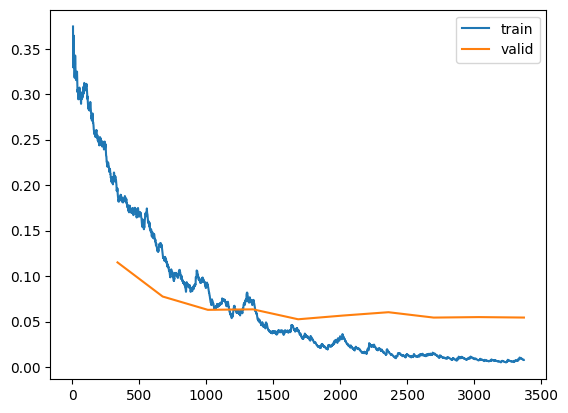

In [ ]:
learn.recorder.plot_loss()

Note that the loss is worse than [1], the main reason being the use of the "tiny" variant of the ViT model.


# Evaluation

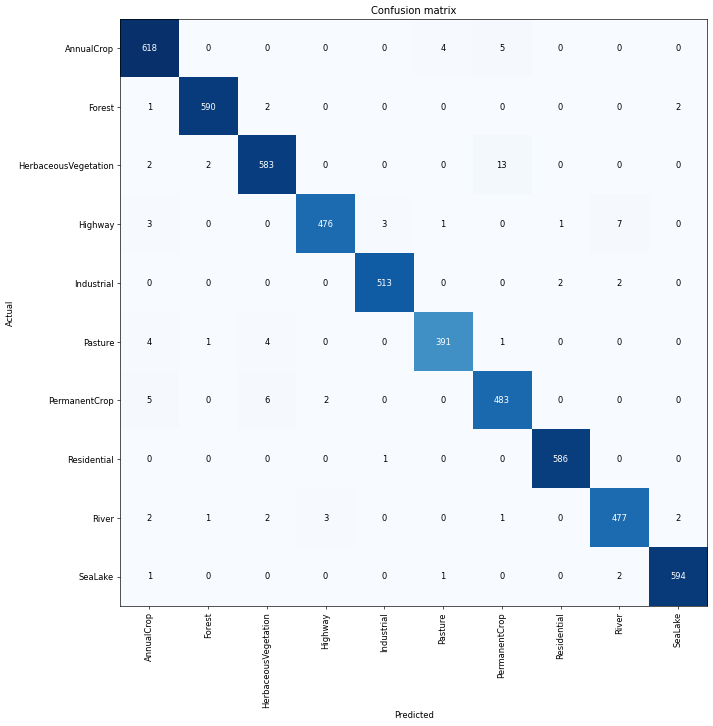

In [ ]:
results = ClassificationInterpretation.from_learner(learn)
results.plot_confusion_matrix(figsize=(12,12), dpi=60)

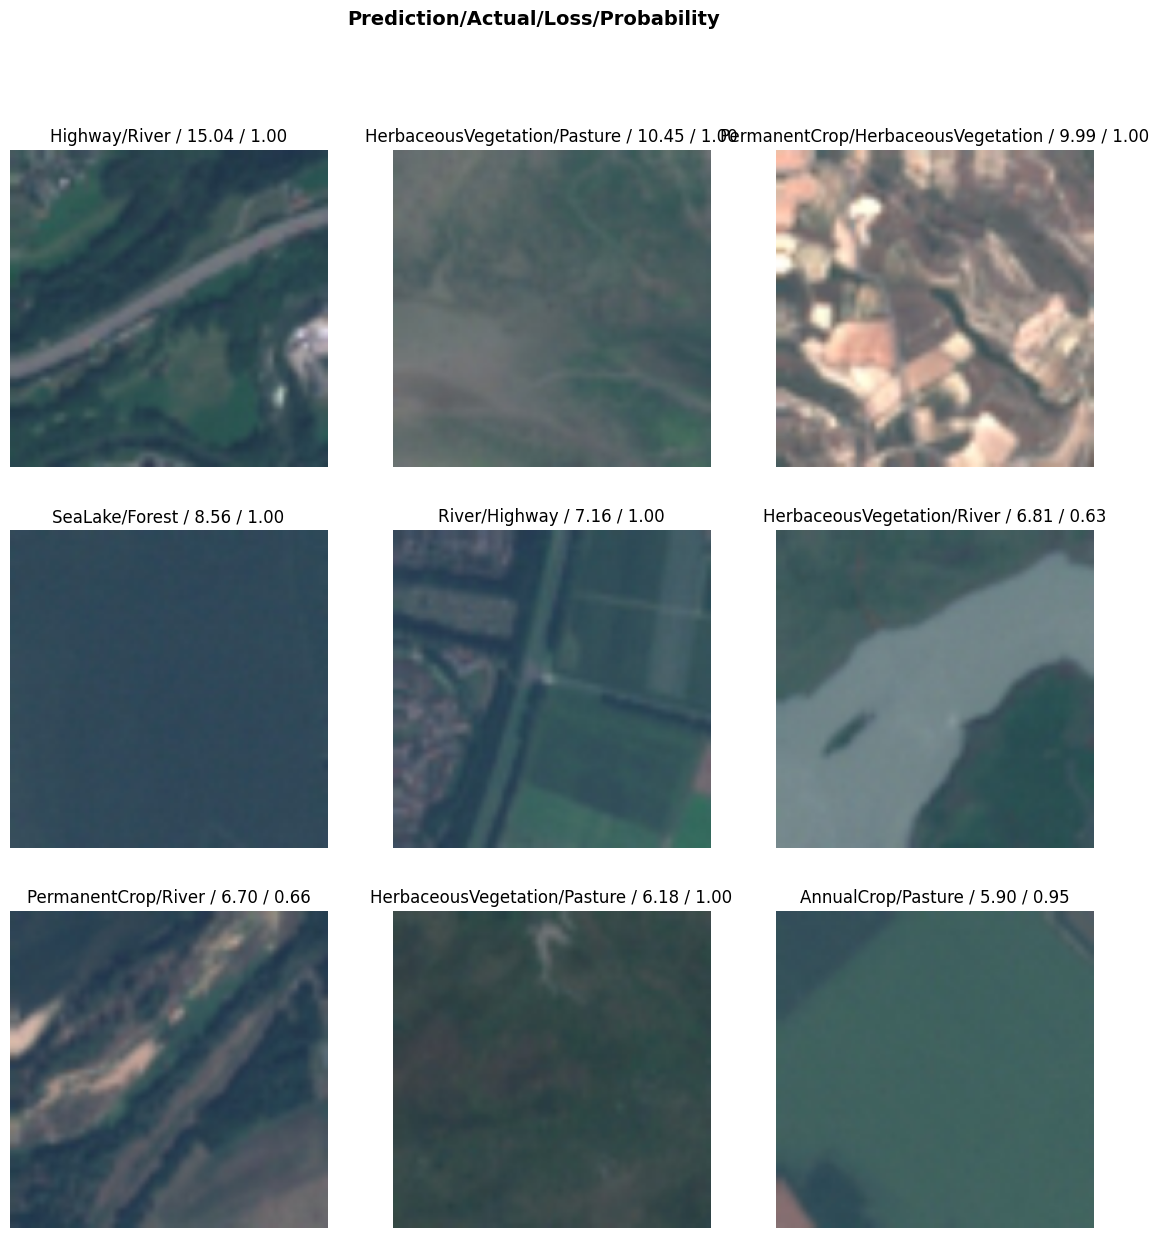

In [ ]:
results.plot_top_losses(9, figsize= (14 ,14))

# Inference

In [ ]:
# Test on getting a label from the finetuned model
clas, clas_idx, probs = learn.predict(fnames[0]);
print(fnames[0])
print(clas)

/content/2750/Forest/Forest_1036.jpg
Forest


In [ ]:
# Test on getting a label from the finetuned model for multiple files
test_dl = learn.dls.test_dl(fnames[:10])
preds = learn.get_preds(dl=test_dl)
class_idxs = preds[0].argmax(dim=0)
res = [dls.vocab[c] for c in class_idxs]
print(res)

['Industrial', 'PermanentCrop', 'Residential', 'Residential', 'Industrial', 'Residential', 'Residential', 'Residential', 'Residential', 'Residential']


# Saving

Saving the model & test on using it.

In [ ]:
learner_name = "perfectos"
model_path = os.path.join(os.getcwd(), 'models')
os.makedirs(model_path, exist_ok=True)
learner_path = os.path.join(model_path, learner_name)
learn.export(learner_path)

In [ ]:
p = learn.path
loaded_learner = load_learner(learner_path, cpu=False)
print(type(loaded_learner))

<class 'fastai.learner.Learner'>


In [ ]:
# load all the files in a dir
files = fnames[0:2]
print('Files for inference: ', files)

# make the test dataloader
dl = loaded_learner.dls.test_dl(files)
print(dl)

# perform the predictions
loaded_learner.get_preds(dl=dl)

Files for inference:  [Path('/content/2750/Forest/Forest_1036.jpg'), Path('/content/2750/Forest/Forest_2566.jpg')]


(tensor([[6.0142e-09, 1.0000e+00, 6.3024e-09, 4.2637e-08, 4.3741e-09, 2.5848e-09,
          3.8486e-08, 3.9553e-09, 3.6342e-08, 5.0204e-10],
         [6.6291e-09, 1.0000e+00, 1.1849e-09, 5.5458e-08, 1.4645e-09, 8.7648e-08,
          5.0859e-09, 6.7418e-08, 7.2651e-09, 4.3837e-10]]),
 None)

# Conclusion

The model after fine-tuning is ok, but could be better. As noted, the results are worse than [1], the main reason being the use of the "tiny" variant of the ViT model. Additionally, the loaded model was not finetuned on ImageNet21K as advised.


## Evaluation

Relating to fast ai: while the code is succint, the documentation of is not very clear.

# References

[1] Ivica Dimitrovski, Ivan Kitanovski, Dragi Kocev, Nikola Simidjievski, Current trends in deep learning for Earth Observation: An open-source benchmark arena for image classification,
ISPRS Journal of Photogrammetry and Remote Sensing, Volume 197, 2023, Pages 18-35, ISSN 0924-2716, https://doi.org/10.1016/j.isprsjprs.2023.01.014. (https://www.sciencedirect.com/science/article/pii/S0924271623000205)